In [1]:
import os
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

/tmp/ipykernel_24928/151913063.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/home/aidin/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/aidin/anaconda3/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:

ground_truth_dir = os.path.join(
    'mall_dataset',
    'ground_truth'
)

images_dir = os.path.join(
    'mall_dataset',
    'frames'
)

ground_truth = scipy.io.loadmat(
    os.path.join(
        'mall_dataset',
        'mall_gt.mat'
    )
)

In [3]:
# Access the frame and count arrays
frame_array = ground_truth['frame']
count_array = ground_truth['count']

# Iterate over the elements in the frame array
for i, (frame, count) in enumerate(zip(frame_array[0], count_array.T[0])):
    # Create a new dictionary to mimic the structure of the first case
    mat_ground_truth = {
        '__header__': ground_truth['__header__'],
        '__version__': ground_truth['__version__'],
        '__globals__': ground_truth['__globals__'],
        'image_info': np.array([[
            np.array([(
                np.array([frame][0][0][0][0]),
                np.array([count][0])
            )], dtype=[('location', 'O'), ('number', 'O')])
        ]], dtype='O')
    }

    # Save each element as a separate mat file
    scipy.io.savemat(
        os.path.join(
            ground_truth_dir,
            f'GT_seq_{i+1:06d}.mat'
        ),
        mat_ground_truth
    )

/home/aidin/anaconda3/lib/python3.8/site-packages/scipy/io/matlab/_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


In [4]:
def plot_img_and_gt(img, gt):
    """
    Plot the image and ground truth data.
    
    Parameters
    ----------
    img : ndarray
        The image to plot.
    gt : dict
        The ground truth data.
    """
    # Plot the image
    plt.imshow(img)
    
    # Plot the ground truth
    plt.scatter(
        gt['image_info'][0][0][0][0][0][:,0],
        gt['image_info'][0][0][0][0][0][:,1],
        c='red',
        s=10
    )
    # Show the plot
    plt.show()
    
def plot_frame(n:int):
    """
    Plot the nth frame.
    
    Parameters
    ----------
    n : int
        The frame number.
    """
    # Load the image
    img = plt.imread(
        os.path.join(
            images_dir,
            f'seq_{n:06d}.jpg'
        )
    )
    # Load the ground truth
    gt = scipy.io.loadmat(
        os.path.join(
            ground_truth_dir,
            f'GT_seq_{n:06d}.mat'
        )
    )
    # Plot the image and ground truth data
    plot_img_and_gt(img, gt)

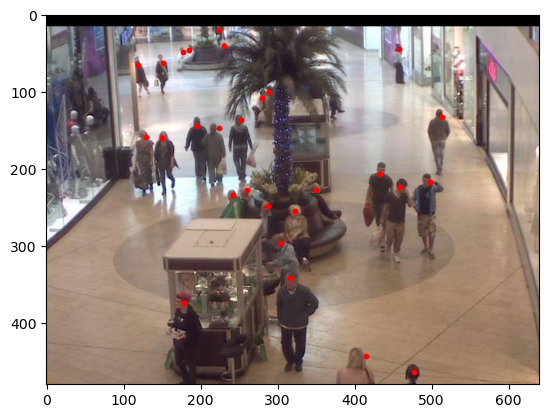

In [5]:
plot_frame(1950)

In [6]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [14]:
root = 'mall_dataset'

path_sets = os.path.join(
    root,
    'frames'
)

img_paths = []
for path in [path_sets]:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [16]:
for img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('frames','ground_truth').replace('seq_','GT_seq_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0][0][0][0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('frames','ground_truth'), 'w') as hf:
            hf['density'] = k

mall_dataset/frames/seq_000658.jpg
(480, 640)
generate density...


/tmp/ipykernel_24928/4051122479.py:24: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')


done.
mall_dataset/frames/seq_001924.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_001200.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_000904.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_000488.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_000892.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_000317.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_000094.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_001254.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_000058.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_000861.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_000125.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_001518.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_000450.jpg
(480, 640)
generate density...
done.
mall_dataset/frames/seq_001432.jpg
(480, 640)
generate den

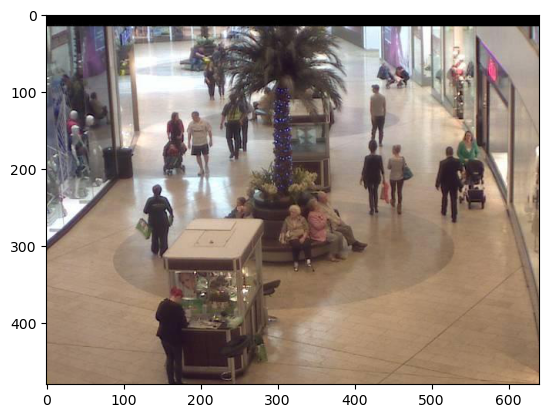

In [20]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[1236]))

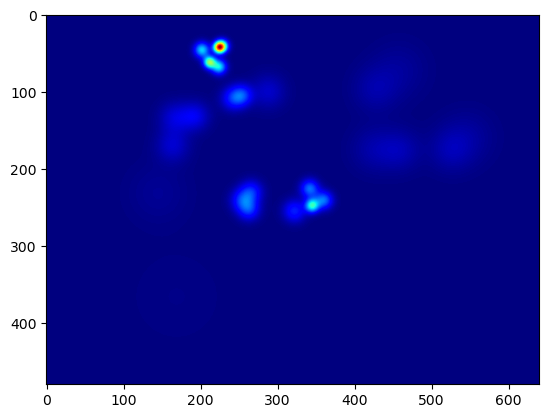

In [21]:
gt_file = h5py.File(img_paths[1236].replace('.jpg','.h5').replace('frames','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [ ]:
file_path = 'mall_dataset.json'

# Open the file in write mode
with open(file_path, 'w') as json_file:
    # Use json.dump to write the list into the JSON file
    json.dump(img_paths, json_file)